# Interacting with outgoing energy distributions in ENDF-6 format (MF=5)

First let's import `sandy` and the other python packages for formatting and postprocessing that are used in this notebook.

In [1]:
import urllib
import yaml

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("notebook")

%matplotlib inline

In [3]:
import pandas as pd

In [4]:
import sandy

## Parsing the data in ENDF-6 format

The first thing that we want to do with an evaluated nuclear data  file in ENDF-6 format is to load its content into python using `sandy`.
By calling `sandy.Endf6.from_file`, the ENDF-6 file is parsed and its content is split into text sections, each of them indexed by a unique combination of MAT, MF and MT numbers. 

Below we report an example using the JEFF-3.1.2 Pu-239 evaluated file available on the [OECD/NEA website](https://www.oecd-nea.org/dbforms/data/eva/evatapes/jeff_31/JEFF312/).
The file content is loaded into the `Endf6` instance that we name `tape`.

In [5]:
url = "https://www.oecd-nea.org/dbforms/data/eva/evatapes/jeff_31/JEFF312/final/JEFF312N9437_0.ASC"
with urllib.request.urlopen(url) as f:
    text = f.read().decode('utf-8')

In [6]:
%%capture
tape = sandy.Endf6.from_text(text)

The combinations of `(MAT MF, MT)` numbers found in the loaded file are accessible using attribute `keys`.

In [7]:
tape.keys

dict_keys([(9437, 1, 451), (9437, 1, 452), (9437, 1, 455), (9437, 1, 456), (9437, 1, 458), (9437, 2, 151), (9437, 3, 1), (9437, 3, 2), (9437, 3, 3), (9437, 3, 4), (9437, 3, 16), (9437, 3, 17), (9437, 3, 18), (9437, 3, 37), (9437, 3, 51), (9437, 3, 52), (9437, 3, 53), (9437, 3, 54), (9437, 3, 55), (9437, 3, 56), (9437, 3, 57), (9437, 3, 58), (9437, 3, 59), (9437, 3, 60), (9437, 3, 61), (9437, 3, 62), (9437, 3, 63), (9437, 3, 64), (9437, 3, 65), (9437, 3, 66), (9437, 3, 67), (9437, 3, 68), (9437, 3, 69), (9437, 3, 70), (9437, 3, 71), (9437, 3, 72), (9437, 3, 73), (9437, 3, 74), (9437, 3, 75), (9437, 3, 76), (9437, 3, 77), (9437, 3, 91), (9437, 3, 102), (9437, 4, 2), (9437, 4, 16), (9437, 4, 17), (9437, 4, 18), (9437, 4, 37), (9437, 4, 51), (9437, 4, 52), (9437, 4, 53), (9437, 4, 54), (9437, 4, 55), (9437, 4, 56), (9437, 4, 57), (9437, 4, 58), (9437, 4, 59), (9437, 4, 60), (9437, 4, 61), (9437, 4, 62), (9437, 4, 63), (9437, 4, 64), (9437, 4, 65), (9437, 4, 66), (9437, 4, 67), (9437, 4, 68

Now, the information available in each `(MAT, MF, MT)` section in ASCII format can be extracted using method `.read_section`, 
as shown below.

In [8]:
mat = 9437  # This is Pu-239
mf = 5
mt = 455

section = tape.read_section(mat, mf, mt)

Let's print some pieces of information that were extracted with `.read_section`.
> `.read_section` returns data hierarchly structures as a `dict` of `dict`.

In [9]:
print(f"""
MAT:{section["MAT"]:>8d}
MF:{section["MF"]:>8d}
MT:{section["MT"]:>8d}
AWR:{section["AWR"]:>8.1f}
PDISTR: {list(section["PDISTR"].keys())}
""")


MAT:    9437
MF:       5
MT:     455
AWR:   237.0
PDISTR: [0, 1, 2, 3, 4, 5, 6, 7]



Delayed-neutron spectra in MT=455 section are given in 8 groups!
Let's recall the the abundance of each delayed-neutron group is available in MF=5 MT=455.

By parsing the section content we can extract the abundance of each delayed-neutron group as a function of incident-neutron energy.
Below er report the abundances for the first group!

In [10]:
distr_1g = section["PDISTR"][0]
pd.DataFrame({
    "energy": distr_1g["E_P"],
    "abundance": distr_1g["P"]
})

,energy,abundance
0,1.00000e-05,3.19064e-02
1,1.00000e+00,2.87971e-02
2,5.00000e+06,2.87971e-02
3,1.30000e+07,4.84569e-02
4,3.00000e+07,4.84569e-02


## Create a `sandy.Edistr` object

Class `sandy.Edistr` was developed to store and process outgoing energy distributions, that is, basically everythingg in a MF=5 section.

The ASCII content in a `sandy.Endf6` instance can be used to intialize s `sandy.Edistr` instance using classmethod `.from_endf6`, where the `sandy.Endf6` object is passed as an argument.

In [11]:
tabs = sandy.Edistr.from_endf6(tape)

> At the moment sandy only works with:
>  - tabulated distributions,
>  - distributions that can be linearly interpolated both on the incoming and outgoing neutron energies.

A `sandy.Edistr` instance contains everything that was given in input, i.e. all spectra for all MT reactions that were found.
Still, we can filter this object to get the data we need using method `.filter_by` which takes a key and a value.

Below we filter the prompt-neutron fission spectra, but we can also add other filters such as on `EIN`, `EOUT`, ... 

In [12]:
pfns = tabs.filter_by("MT", 18)
pfns

       MAT  MT  K         EIN        EOUT       VALUE
0     9437  18  0 1.00000e-05 1.00000e-05 1.76602e-12
1     9437  18  0 1.00000e-05 1.00000e-04 5.58466e-12
2     9437  18  0 1.00000e-05 1.00000e-03 1.76602e-11
3     9437  18  0 1.00000e-05 1.00000e-02 5.58466e-11
4     9437  18  0 1.00000e-05 1.00000e-01 1.76602e-10
...    ...  .. ..         ...         ...         ...
6345  9437  18  0 3.00000e+07 2.42000e+07 1.89471e-12
6346  9437  18  0 3.00000e+07 2.44000e+07 1.70367e-12
6347  9437  18  0 3.00000e+07 2.46000e+07 1.53189e-12
6348  9437  18  0 3.00000e+07 2.48000e+07 1.37743e-12
6349  9437  18  0 3.00000e+07 2.50000e+07 1.23854e-12

[6350 rows x 6 columns]

SANDY is based on composition rather than inheritance, and the source data of an instance can always be found in attribute `data` as a `pandas.DataFrame`

Being a dataframe, we can use all `pandas` features to manipulate data, such as extracting all incoming neutron energies for PFNS.

In [13]:
pfns.data.EIN.unique()

array([1.0e-05, 1.0e+05, 5.0e+05, 1.0e+06, 2.0e+06, 3.0e+06, 4.0e+06,
       5.0e+06, 6.0e+06, 7.0e+06, 8.0e+06, 9.0e+06, 1.0e+07, 1.1e+07,
       1.2e+07, 1.3e+07, 1.4e+07, 1.5e+07, 1.8e+07, 2.0e+07, 2.2e+07,
       2.4e+07, 2.6e+07, 2.8e+07, 3.0e+07])

Here we display the PFNS for incoming neutron energies below $10^{-5}$ eV and between $10^{-5}$ eV and $10^{5}$ eV.

In [14]:
pfns.filter_by("EIN", 1E-5)

      MAT  MT  K         EIN        EOUT       VALUE
0    9437  18  0 1.00000e-05 1.00000e-05 1.76602e-12
1    9437  18  0 1.00000e-05 1.00000e-04 5.58466e-12
2    9437  18  0 1.00000e-05 1.00000e-03 1.76602e-11
3    9437  18  0 1.00000e-05 1.00000e-02 5.58466e-11
4    9437  18  0 1.00000e-05 1.00000e-01 1.76602e-10
..    ...  .. ..         ...         ...         ...
249  9437  18  0 1.00000e-05 2.42000e+07 2.95328e-14
250  9437  18  0 1.00000e-05 2.44000e+07 2.52658e-14
251  9437  18  0 1.00000e-05 2.46000e+07 2.16128e-14
252  9437  18  0 1.00000e-05 2.48000e+07 1.84859e-14
253  9437  18  0 1.00000e-05 2.50000e+07 1.58096e-14

[254 rows x 6 columns]

In [15]:
pfns.filter_by("EIN", 1E5)

      MAT  MT  K         EIN        EOUT       VALUE
0    9437  18  0 1.00000e+05 1.00000e-05 1.76379e-12
1    9437  18  0 1.00000e+05 1.00000e-04 5.57760e-12
2    9437  18  0 1.00000e+05 1.00000e-03 1.76379e-11
3    9437  18  0 1.00000e+05 1.00000e-02 5.57760e-11
4    9437  18  0 1.00000e+05 1.00000e-01 1.76379e-10
..    ...  .. ..         ...         ...         ...
249  9437  18  0 1.00000e+05 2.42000e+07 3.04724e-14
250  9437  18  0 1.00000e+05 2.44000e+07 2.60779e-14
251  9437  18  0 1.00000e+05 2.46000e+07 2.23146e-14
252  9437  18  0 1.00000e+05 2.48000e+07 1.90923e-14
253  9437  18  0 1.00000e+05 2.50000e+07 1.63335e-14

[254 rows x 6 columns]

Below we plot all prompt-fission neutron spectra provided for different incoming neutron energies.
Using `seaborn` the plot shows the average spectrum (**not the weighted-average spectrum!**) and the deviation (1$\sigma$) as a solid band.

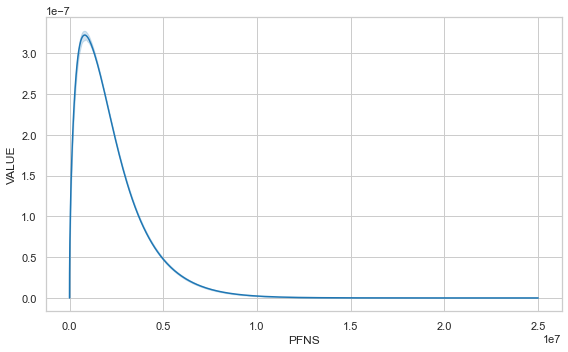

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=pfns.data, x="EOUT", y="VALUE", ax=ax)
ax.set_xlabel("Prompt-fission neutron energy / $MeV$")
ax.set_xlabel("PFNS")

plt.tight_layout()

If you suspect that the spectra are not normalized, you can call method `.normalize` to impose a normalization to unit of all probablity density functions.

Calling method `.get_integrals()` you can check the integral of each spectrum (it should be 1).

In [17]:
pfns.normalize().get_integrals()

,MAT,MT,K,EIN,INTEGRAL
0,9437,18,0,1.00000e-05,1.00000e+00
1,9437,18,0,1.00000e+05,1.00000e+00
2,9437,18,0,5.00000e+05,1.00000e+00
3,9437,18,0,1.00000e+06,1.00000e+00
4,9437,18,0,2.00000e+06,1.00000e+00
5,9437,18,0,3.00000e+06,1.00000e+00
6,9437,18,0,4.00000e+06,1.00000e+00
7,9437,18,0,5.00000e+06,1.00000e+00
8,9437,18,0,6.00000e+06,1.00000e+00
9,9437,18,0,7.00000e+06,1.00000e+00
